0.2894603148621107
2.5624471716514954
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)   

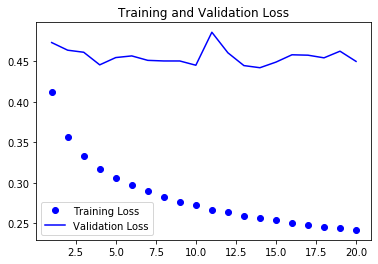

CPU times: user 19min 19s, sys: 1min 46s, total: 21min 5s
Wall time: 4min 31s


In [3]:
%%time

# 1D ConvNet to jena climate data

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# jena 날씨 데이터셋 import
data_dir = '/Users/jaekunpark/Dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]


# Data Parsing
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


# Data Regularization
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

'''
data = Data Regularization에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
lookback = 1440 : 10일 전 데이터로 돌아간다 (입력으로 사용하기 위해 거슬러 올라갈 타임스텝)
delay = 144 : 24시간이 지난 데이터가 타겟이 된다. (타겟으로 사용할 미래의 타임스텝)
min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스. 검증,테스트 데이터를 분리하는데 사용
shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
batch_size = 배치의 샘플 수
step = 6 : 데이터를 샘플링할 타임스텝 간격(1시간 마다 데이터 포인트 하나를 샘플링하기 위해 6으로 지정)
'''

# 시계열 데이터와 타깃을 반환하는 generator function
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        # samples = (128, 240, 14)
        targets = np.zeros((len(rows), ))
        # targets = (128, )
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            
# 훈련, 검증, 테스트 제네레이터 준비
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                     shuffle = True, step = step, batch_size = batch_size)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                     shuffle = True, step = step, batch_size = batch_size)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None,
                     shuffle = True, step = step, batch_size = batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
    # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수 
    # generator()함수는 while문을 이용하여 무한 반복되므로 한 번 순회하는 횟수를 알려준다
test_steps = (len(float_data) - 300001 - lookback) // batch_size
    # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
    
# 상식적인 기준 모델의 MAE(Mean Absolute Error)계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        val_mae = np.mean(batch_maes)
        celsius_mae = val_mae * std[1]
    print(np.mean(batch_maes))
    print(celsius_mae)
    
evaluate_naive_method()

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = 'relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

# Graph
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss ,'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
검증 MAE가 0.40대에 머물러 있다.
작은 컨브넷을 사용해서 상식 수준의 기준점을 넘지 못했다.
이는 컨브넷이 입력 시계열에 있는 패턴을 보고 이 패턴의 시간 축이 위치(시작인지 끝 부분인지 등)을 고려하지 않기 때문이다.
최근 데이터 포인트일수록 오래된 데이터 포인트와는 다르게 해석해야 하기 때문에 컨브넷이 의미있는 결과를 만들지 못한다.

이런 컨브넷의 한계는 IMDB데이터에서는 문제가 되지 않는다. 긍정 또는 부정적인 감성과 연관된 키워드 패턴의 중요성은 입력 시퀀스에 나타난 위치와
무관하기 때문이다.

컨브넷의 속도와 경량함을 RNN의 순서 감지 능력과 결합하는 한 가지 전략은 1D 컨브넷을 RNN 이전에 전처리 단계로 사용하는 것이다.
수천 개의 스텝을 가진 시퀀스 같이 RNN으로 처리하기에는 현실적으로 너무 긴 시퀀스를 다룰 때 특별히 도움이 된다.
컨브넷이 긴 입력 시퀀스를 더 짧은 고수준 특성의 (다운샘플된) 시퀀스로 변환한다. 추출된 특성의 시퀀스는 RNN 파트의 입력이 된다.

0.2825168400734694
2.500980067457737
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_7 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 500 steps, validate

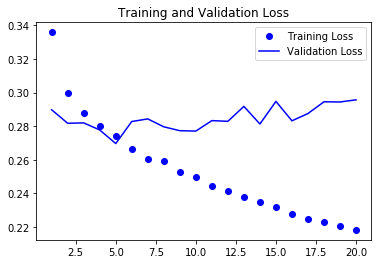

CPU times: user 1h 29min 45s, sys: 19min 10s, total: 1h 48min 55s
Wall time: 26min 48s


In [4]:
%%time

# 1D ConvNet + RNN to jena climate data

import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

# jena 날씨 데이터셋 import
data_dir = '/Users/jaekunpark/Dataset/jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')
f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]


# Data Parsing
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values


# Data Regularization
mean = float_data[:200000].mean(axis = 0)
float_data -= mean
std = float_data[:200000].std(axis = 0)
float_data /= std

'''
data = Data Regularization에서 정규화한 부동 소수 데이터로 이루어진 원본 배열
lookback = 1440 : 10일 전 데이터로 돌아간다 (입력으로 사용하기 위해 거슬러 올라갈 타임스텝)
delay = 144 : 24시간이 지난 데이터가 타겟이 된다. (타겟으로 사용할 미래의 타임스텝)
min_index, max_index : 추출할 타임스텝의 범위를 지정하기 위한 data배열의 인덱스. 검증,테스트 데이터를 분리하는데 사용
shuffle : 샘플을 섞을지, 시간 순서대로 추출할지를 결정
batch_size = 배치의 샘플 수
step = 6 : 데이터를 샘플링할 타임스텝 간격(1시간 마다 데이터 포인트 하나를 샘플링하기 위해 6으로 지정)
'''

# 시계열 데이터와 타깃을 반환하는 generator function
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        # samples = (128, 240, 14)
        targets = np.zeros((len(rows), ))
        # targets = (128, )
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets
            
# 고밀도 데이터 제네레이터로 jena dataset 
lookback = 1440
step = 3
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 0, max_index = 200000,
                     shuffle = True, step = step)
val_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 200001, max_index = 300000,
                     shuffle = True, step = step)
test_gen = generator(float_data, lookback = lookback, delay = delay, min_index = 300001, max_index = None,
                     shuffle = True, step = step)

val_steps = (300000 - 200001 - lookback) // batch_size
    # 전체 검증 세트를 순회하기 위해 val_gen에서 추출할 횟수 
    # generator()함수는 while문을 이용하여 무한 반복되므로 한 번 순회하는 횟수를 알려준다
test_steps = (len(float_data) - 300001 - lookback) // batch_size
    # 전체 테스트 세트를 순회하기 위해 test_gen에서 추출할 횟수
    
# 상식적인 기준 모델의 MAE(Mean Absolute Error)계산
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds - targets))
        batch_maes.append(mae)
        val_mae = np.mean(batch_maes)
        celsius_mae = val_mae * std[1]
    print(np.mean(batch_maes))
    print(celsius_mae)
    
evaluate_naive_method()

model = Sequential()
model.add(layers.Conv1D(32, 5, activation = 'relu', input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation = 'relu'))
model.add(layers.GRU(32, dropout = 0.1, recurrent_dropout = 0.5))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer = RMSprop(), loss = 'mae')
history = model.fit(train_gen,
                    steps_per_epoch = 500,
                    epochs = 20,
                    validation_data = val_gen,
                    validation_steps = val_steps)

# Graph
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()
plt.plot(epochs, loss ,'bo', label = 'Training Loss')
plt.plot(epochs, val_loss, 'b', label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()